# Chapter 44-appendix. Pairs Trading AUS-CAN

MSCI Australia Index ETF & Canada Index ETF price 를 이용한 pair trading

In [1]:
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.regression.linear_model as rg
import arch.unitroot as at
%matplotlib inline
stock1 = 'KAL'
stock2 = 'ASIANA'
code1 = "003490"
code2 = "020560"

C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
start = pd.to_datetime('2015-01-01')
end =  pd.to_datetime('2018-01-01')
pair = pd.DataFrame(columns=[stock1, stock2])
pair[stock1] = pd.DataFrame(
        get_price_data({'q': code1, 'i': "86400", 'x': "KRX", 'p': "10Y" }))['Close'].loc[start : end]
pair[stock2] =pd.DataFrame(
        get_price_data({'q': code2, 'i': "86400", 'x': "KRX", 'p': "10Y" }))['Close'].loc[start : end]

pair.index = pd.to_datetime(pair.index.date)
pair.index.name = 'Date'
pair.columns = ['aus', 'can']

In [3]:
int1 = pair

data = pd.read_csv("Data//Pairs-Trading-Analysis-Data.txt", index_col='Date', parse_dates=True)
int1 = data.loc[:, ['aus', 'can']]

In [4]:
int1.head(2)

,aus,can
Date,,
2015-01-02,45150.0,7070.0
2015-01-05,46200.0,7200.0


### 2. Pairs Identification

### 2.1. AUS-CAN Returns Calculation

In [5]:
int1['ausret'] = int1['aus'] / int1['aus'].shift(1) - 1
int1['canret'] = int1['can'] / int1['can'].shift(1) - 1
int1.head(3)

,aus,can,ausret,canret
Date,,,,
2015-01-02,45150.0,7070.0,NaN,NaN
2015-01-05,46200.0,7200.0,0.023256,0.018388
2015-01-06,45650.0,7080.0,-0.011905,-0.016667


In [6]:
int1['ausret'] = int1['aus'] / int1['aus'].shift(1) - 1
int1['canret'] = int1['can'] / int1['can'].shift(1) - 1
int1[np.isnan(int1)] = 0

In [7]:
int1.head(3)

,aus,can,ausret,canret
Date,,,,
2015-01-02,45150.0,7070.0,0.000000,0.000000
2015-01-05,46200.0,7200.0,0.023256,0.018388
2015-01-06,45650.0,7080.0,-0.011905,-0.016667


### 2.2. AUS-CAN Returns Correlation

short-term relationship

In [8]:
print("AUS-CAN Returns Correlation")
print("")
print(int1.loc[:, ['ausret', 'canret']].corr())

AUS-CAN Returns Correlation

          ausret    canret
ausret  1.000000  0.613813
canret  0.613813  1.000000


### 2.3. AUS-CAN Prices Chart

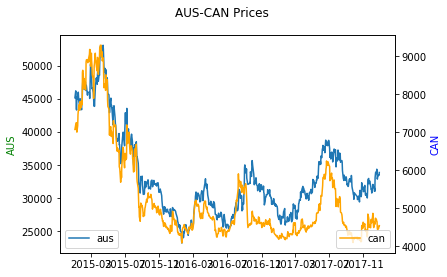

In [9]:
fig1, ax1 = plt.subplots()                    # default (1,1)
ax1.plot(int1['aus'])
ax1.legend(loc='lower left')
ax2 = ax1.twinx()                               # creating a twin Axes
ax2.plot(int1['can'], color="orange")    # sharing the xaxis
ax2.legend(loc='lower right')
plt.suptitle('AUS-CAN Prices');
ax1.set_ylabel('AUS', color='g')
ax2.set_ylabel('CAN', color='b');

### 3. Pairs Spread Co-Integration

### 3.1. AUS-CAN Spread Calculation

### OLS regression doesn't include constant (linear regression without intersection) 
  - beta 에만 집중
  
  - canadian index 가 변화할 때 예상되는 austrialia index 와 실제 australia index 의 차이 : aus_price_spread

In [10]:
lmint1 = rg.OLS(int1['aus'], int1['can']).fit()         # linear regression model
intb1 = lmint1.params[0]                                   # intersection 없으므로 beta = params[0]
int1['spread'] = int1['aus'] - intb1 * int1['can']    # spread (forecasting errors) = actual aus price - expected aus price

In [11]:
print("beta = ", intb1)
int1.head(2)

beta =  6.16737058295


,aus,can,ausret,canret,spread
Date,,,,,
2015-01-02,45150.0,7070.0,0.000000,0.000000,1546.689979
2015-01-05,46200.0,7200.0,0.023256,0.018388,1794.931803


### 3.2. AUS-CAN Spread Chart

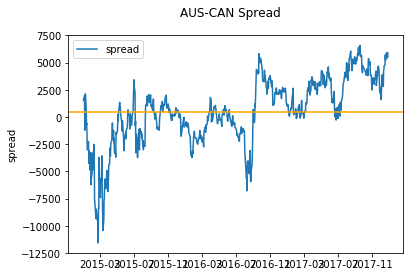

In [12]:
fig2, ax = plt.subplots()
ax.plot(int1['spread'])
ax.axhline(int1['spread'].mean(), color="orange")    # corresponding spread mean
ax.legend(loc="upper left")
plt.suptitle('AUS-CAN Spread')
plt.ylabel('spread');

## 위에서 선택한 AUS index 와 CAN index 가 pair trading 의 조건을 만족하는지 TEST

### Engle-Granger co-integration Method 를 이용한 Test

* two paired assets prices 의 spread (linear regression residuals) 가 stationary 인지 여부 Test
<ol>
    <li> AUS 와 CAN price 가 stationary 인지 여부 Test</li>
    <li> AUS 와 CAN 의 daily return 이 stationary 인지 여부 Test</li>
    <li>AUS-CAN 의 spread 가 stationary 인지 여부 Test : Augmented Dickey-Fuller Co-Integration Test </li>
     <li> AUS-CAN 의 sperady 가 stationary 인지 여부 double check : Phillips-Perron Co-Integration Test </li>
</ol>

3, 4 에서 spread 가 non-stationary 로 확인되면 paris trading 전략을 계속 진행할 수 없음.

### 3.3. AUS-CAN  Prices are Non-Stationary

In [13]:
print("AUS Prices Augmented Dickey-Fuller Test")
print("")
print(at.ADF(int1['aus']))
print("")
print("CAN Prices Augmented Dickey-Fuller Test")
print("")
print(at.ADF(int1['can']))

AUS Prices Augmented Dickey-Fuller Test

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.133
P-value                         0.232
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

CAN Prices Augmented Dickey-Fuller Test

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.707
P-value                         0.428
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


위에서 AUS 와 CAN 의 price 는 p-value > 0.05 이므로 null hypothesis ("There is a unit root") 를 지지하므로 non-stationary 이다.

### 3.4. AUS-CAN Returns are Stationary

In [14]:
print("AUS Prices Differences Augmented Dickey-Fuller Test")
print("")
print(at.ADF(int1['ausret'] ))
print("")
print("CAN Prices Differences Augmented Dickey-Fuller Test")
print("")
print(at.ADF(int1['canret'] ))

AUS Prices Differences Augmented Dickey-Fuller Test

   Augmented Dickey-Fuller Results   
Test Statistic                -12.983
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

CAN Prices Differences Augmented Dickey-Fuller Test

   Augmented Dickey-Fuller Results   
Test Statistic                -26.856
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


위에서 AUS 와 CAN 의 returns 는 p-value < 0.05 이므로 null hypothesis ("There is a unit root") 를 기각 하므로 stationary 이다.

### 3.5. AUS-CAN Augmented Dickey-Fuller Co-Integration Test

In [15]:
print("AUS-CAN Augmented Dickey-Fuller Co-Integration Test")
print("")
print(at.ADF(int1['spread']))

AUS-CAN Augmented Dickey-Fuller Co-Integration Test

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.488
P-value                         0.119
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


p-value > 0.05 이지만, critical value -2.57 보다 크므로 80% statistical confidence 로 stationary 하다고 인정 (예외적인 case)

### 3.6. AUS-CAN Phillips-Perron Co-Integration Test

In [16]:
print("AUS-CAN Phillips-Perron Co-Integration Test")
print("")
print(at.PhillipsPerron(int1['spread']))

AUS-CAN Phillips-Perron Co-Integration Test

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.903
P-value                         0.045
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Phillips-Perron Co-Integration Test 로 위의 ADF Test 결과 validate

stationary 가 confirm 되면 pairs trading 전략을 진행할 수 있다.

## 4. Pairs Trading Strategy

### 4.1. AUS-CAN Rolling Beta Calculation

#### AUS-CAN Rolling Covariance Calculation

* 63 : 1 quarter, piarwise=True : multi-index dataframe return

In [17]:
rolling_cov = int1.loc[:, ['aus', 'can']].rolling(window=63).cov(int1.loc[:, ['aus', 'can']], pairwise=True)

In [18]:
rolling_cov.tail(4) 

aus            can
Date                                       
2017-12-27 aus  1.435945e+06  172350.806452
           can  1.723508e+05   44588.709677
2017-12-28 aus  1.523277e+06  176478.046595
           can  1.764780e+05   44086.917563

In [19]:
idx = pd.IndexSlice          # create an object to perform multi-index slicing
rolling_cov= rolling_cov.loc[idx[:, 'aus'], 'can']

In [20]:
rolling_cov.tail(2)

Date           
2017-12-27  aus    172350.806452
2017-12-28  aus    176478.046595
Name: can, dtype: float64

Convert Date + Asset index into Date index by making Asset at index level 1 into a new column (asset name)

In [21]:
rolling_cov = rolling_cov.reset_index(level=1)

In [22]:
rolling_cov.tail(3)    # cov(aus, can)

,level_1,can
Date,,
2017-12-26,aus,165694.700461
2017-12-27,aus,172350.806452
2017-12-28,aus,176478.046595


#### CAN Rolling Variance Calculation

In [23]:
rolling_var = int1['can'].rolling(window=63).var()

#### AUS-CAN Rolling Beta Calculation and Chart
$Rolling Beta _{aus-can}  = {Rolling COV_{aus-can}}  \div  {Rolling VAR_{can}}$

In [24]:
rolling_var.tail(3)

Date
2017-12-26    44866.820276
2017-12-27    44588.709677
2017-12-28    44086.917563
Name: can, dtype: float64

In [25]:
int1['rolling_beta'] = rolling_cov['can'] / rolling_var

In [26]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta
Date,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957


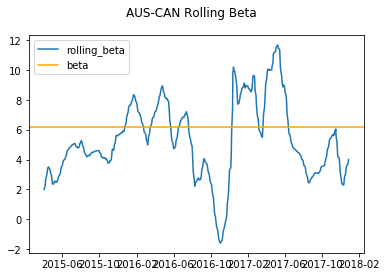

In [27]:
fig3, ax = plt.subplots()
ax.plot(int1['rolling_beta'])
ax.axhline(intb1, color="orange", label="beta")
ax.legend(loc="upper left")
plt.suptitle('AUS-CAN Rolling Beta');

### 4.2. AUS-CAN Rolling Spread Calculation and Chart

In [28]:
int1['rolling_spread'] = int1['aus'] - int1['rolling_beta'] * int1['can']

In [29]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread
Date,,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840


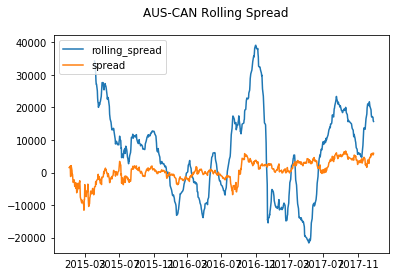

In [30]:
fig4, ax = plt.subplots()
ax.plot(int1['rolling_spread'])
ax.plot(int1['spread'])
ax.legend(loc="upper left")
plt.suptitle('AUS-CAN Rolling Spread');

### 4.3. AUS-CAN Rolling Spread Z-Score Calculation and Chart

rolling z-score 의 목적은 look-ahead bias 제거가 목적. mean 을 subtract 하여 centering 해주고, std 로 normalize 해 준다.

z-score 는 spread 가 spread 의 mean 으로부터 std 몇 개 만큼 떨어져 있는가를 표시한다.

$$ Z_n = \frac{S_n - \mu_n}{\sigma_n}$$

$$(Rolling \ Zscore) = \frac{(Rolling\ Spread) - (Rolling\ Mean\ of\ Rolling\ Spread)}{(Rolling \ STD)}$$

* 모도 rolling form 으로 계산

In [31]:
int1['rolling_zscore'] = (int1['rolling_spread'] - int1['rolling_spread'].rolling(window=63).mean()) / \
                 int1['rolling_spread'].rolling(window=63).std()

In [32]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore
Date,,,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605


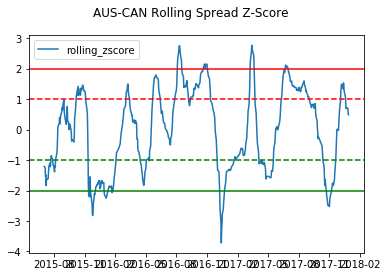

In [33]:
fig5, ax = plt.subplots()
ax.plot(int1['rolling_zscore'])
ax.axhline((-2), color="green")
ax.axhline((-1), color="green", linestyle='--')
ax.axhline((2), color="red")
ax.axhline((1), color="red", linestyle='--')
ax.legend(loc="upper left")
plt.suptitle('AUS-CAN Rolling Spread Z-Score');

### 4.4. AUS-CAN Trading Strategy Signals and Chart

zscore 가 -2 std 위쪽(zscore > -2)에서 아래쪽(zscore < -2)으로 하향 돌파 : Enter long spread trade (buying AUS stock / selling CAN stock in proportion to rolling beta

zscore 가 -1 std 아래쪽(zscore < -1)에서 위쪽(zscore > -1)으로 상향 돌파 : Exit long spread trade (mean reversion : exit 신호)

zscore 가 +2 std 아래쪽(zscore < +2)에서 위쪽(zscore > +2)으로 상향 돌파 : Enter short spread trade (selling AUS stock / buying CAN stock in proportion to rolling beta

zscore 가 + 1 std 위쪽(zscore > +1)에서 아래쪽(zscore < +1)으로 하향 돌파 : Exit short spread trade

* 이것은 mean reversion(평균회귀) 에 근거한 전략임.

-1 < zscore < +1 : spread 가 std 를 벗어나지 않으므로 통계적으로 표준편차 범위이므로 고/저 평가 판단할 수 없음

zscore < -2  : spread < 2 std 를 벗어났으므로 aus 가 표준편차 범위 이상으로 can 에 대해 확실히 상대적 저평가되고 can 이 상대적 고평가 상태

zscore > 2   : spread > 2 std 를 벗어났으므로 aus 가 표준편차 범위 이상으로 can 에 대해 확실히 상대적 고평가되고 can 이 상대적 저평가 상태

*  DataFrame.iterrows() : Iterate over DataFrame rows as (index, Series) pairs.

### Bands Threshold of Trading Signals

Long Pair Spread Trade : 

* Enter long signal: Previous (Z-Score > -2) and Current (Z-Score < -2)
* Exit &nbsp;  long signal: Previous (Z-Score < -1) and Current (Z-Score  > -1)

Short Pair Spread Trade :

* Enter short signal: Previous (Z-Score < +2) and Current (Z-Score > +2)
* Exit &nbsp; short signal: Previous (Z-Score > +1) and Current (Z-Score < +1)

위의 Strategy 에 따라, moving z-score 를 이용하여 trading signal 을 계산한다. 이 때 backtesting bias 를 피하기 위해 one day after 에 signal 이 나오도록 1 day shift(전일) 한 rolling_zscore(-1) 과 2 day shift (전전일) 한 rolling_zscore(-2) 의 두개 column 을 추가 한다.

In [34]:
int1['rolling_zscore(-1)'] = int1['rolling_zscore'].shift(1)     # current zscore
int1['rolling_zscore(-2)'] = int1['rolling_zscore'].shift(2)     # previous zscore
int1['signal'] = 0
signal = 0
for i, r in enumerate(int1.iterrows()):
    if r[1]['rolling_zscore(-2)'] > -2 and r[1]['rolling_zscore(-1)'] < -2: # enter long spread trade
        signal = -2                                                            
    elif r[1]['rolling_zscore(-2)'] < -1 and r[1]['rolling_zscore(-1)'] > -1: # exit long spread trade
        signal = -1
    elif r[1]['rolling_zscore(-2)'] < 2 and r[1]['rolling_zscore(-1)'] > 2: # enter short spread trade
        signal = 2
    elif r[1]['rolling_zscore(-2)'] > 1 and r[1]['rolling_zscore(-1)'] < 1: # exit short spread trade
        signal = 1
    else:
        signal = 0
    #int1.iloc[i, 10] = signal               # row : i, column : signal
    int1.iloc[i, int1.columns.get_loc('signal')] = signal

In [35]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal
Date,,,,,,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591,0.723520,0.692140,0
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406,0.695591,0.723520,0
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605,0.512406,0.695591,0


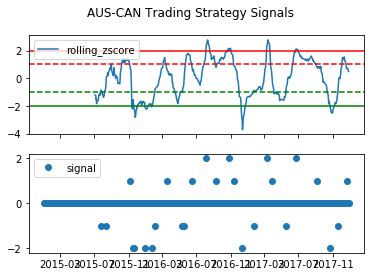

In [36]:
fig6, ax = plt.subplots(2, sharex=True)         # share xaxis

ax[0].plot(int1['rolling_zscore'])
ax[0].axhline((-2), color="green")
ax[0].axhline((-1), color="green", linestyle='--')
ax[0].axhline((2), color="red")
ax[0].axhline((1), color="red", linestyle='--')
ax[0].legend(loc="upper left")

ax[1].plot(int1['signal'], marker='o', linestyle='')        
ax[1].legend(loc='upper left')

plt.suptitle('AUS-CAN Trading Strategy Signals');

### 4.5. AUS-CAN Trading Strategy Positions and Chart

In [37]:
int1['position'] = 0
position = 0
for i, r in enumerate(int1.iterrows()):
    if r[1]['signal'] == -2:
        position = 1             # enter long spread trade
    elif r[1]['signal'] == -1:
        position = 0             # no longer trade
    elif r[1]['signal'] == 2:
        position = -1            # enter short spread trade
    elif r[1]['signal'] == 1:
        position = 0             # no longer trade
    else:
        position = int1.loc[:, 'position'][i-1]
    #int1.iloc[i, 11] = position
    int1.iloc[i, int1.columns.get_loc('position')] = position

Text(0.5,0.98,'AUS-CAN Trading Strategy Positions')

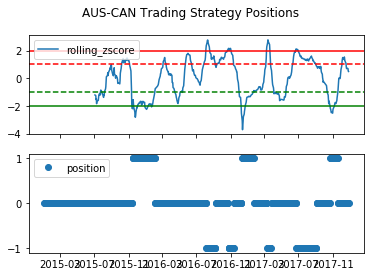

In [38]:
fig7, ax = plt.subplots(2, sharex=True)

ax[0].plot(int1['rolling_zscore'])
ax[0].axhline((-2), color="green")
ax[0].axhline((-1), color="green", linestyle='--')
ax[0].axhline((2), color="red")
ax[0].axhline((1), color="red", linestyle='--')
ax[0].legend(loc="upper left")

# 1 : long position, -1 : short position  0: no longer trading
ax[1].plot(int1['position'], marker='o', linestyle='')        
ax[1].legend(loc='upper left')

plt.suptitle('AUS-CAN Trading Strategy Positions')

In [39]:
int1.tail()

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal,position
Date,,,,,,,,,,,,
2017-12-21,32850.0,4465.0,-0.029542,-0.037716,5312.690347,3.526392,17104.660167,0.692140,0.803180,1.062930,1,0
2017-12-22,33150.0,4430.0,0.009132,-0.007839,5828.548318,3.594171,17227.821533,0.723520,0.692140,0.803180,0,0
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591,0.723520,0.692140,0,0
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406,0.695591,0.723520,0,0
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605,0.512406,0.695591,0,0


## 5. Pairs Strategy Performance Comparison

### 5.1. AUS-CAN Trading Strategy Daily Returns

#### AUS-CAN Trading Strategy Spread Returns

In [40]:
int1['return_spread'] = int1['ausret'] - int1['rolling_beta'] * int1['canret']

In [41]:
# AUS-CAN Strategy Without Trading Commissions
int1['return'] = int1['return_spread'] * int1['position']

In [42]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal,position,return_spread,return
Date,,,,,,,,,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591,0.723520,0.692140,0,0,-0.022788,-0.0
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406,0.695591,0.723520,0,0,-0.062024,-0.0
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605,0.512406,0.695591,0,0,0.016367,0.0


In [43]:
# AUS-CAN Strategy With Trading Commissions (0.1% Per Trade)
int1['position(-1)'] = int1['position'].shift(1)
int1['commission'] = 0
commission = 0

In [44]:
int1.tail()

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal,position,return_spread,return,position(-1),commission
Date,,,,,,,,,,,,,,,,
2017-12-21,32850.0,4465.0,-0.029542,-0.037716,5312.690347,3.526392,17104.660167,0.692140,0.803180,1.062930,1,0,0.103458,0.0,0.0,0
2017-12-22,33150.0,4430.0,0.009132,-0.007839,5828.548318,3.594171,17227.821533,0.723520,0.692140,0.803180,0,0,0.037306,0.0,0.0,0
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591,0.723520,0.692140,0,0,-0.022788,-0.0,0.0,0
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406,0.695591,0.723520,0,0,-0.062024,-0.0,0.0,0
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605,0.512406,0.695591,0,0,0.016367,0.0,0.0,0


위에서 long or short signal 이 나왔으나 이미 전일 취한 position 과 같은 거래의 signal 인 경우 새로운 거래를 않으므로 commission = 0

In [45]:
for i, r in enumerate(int1.iterrows()):
    if (r[1]['signal'] == -2 or r[1]['signal'] == -1 or r[1]['signal'] == 2 or r[1]['signal'] == 1) \
            and r[1]['position'] != r[1]['position(-1)']:
        commission  = 0.001
    else:
        commission  = 0.000
    #int1.iloc[i, 15] = commission 
    int1.iloc[i, int1.columns.get_loc('commission')] = commission

int1['return_c'] = int1['return'] - int1['commission']

In [46]:
int1.tail(3)

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal,position,return_spread,return,position(-1),commission,return_c
Date,,,,,,,,,,,,,,,,,
2017-12-26,33500.0,4470.0,0.010558,0.009029,5931.853494,3.693034,16992.137252,0.695591,0.723520,0.692140,0,0,-0.022788,-0.0,0.0,0.0,-0.0
2017-12-27,33450.0,4540.0,-0.001493,0.015660,5450.137553,3.865346,15901.327546,0.512406,0.695591,0.723520,0,0,-0.062024,-0.0,0.0,0.0,-0.0
2017-12-28,33850.0,4535.0,0.011958,-0.001101,5880.974406,4.002957,15696.588840,0.486605,0.512406,0.695591,0,0,0.016367,0.0,0.0,0.0,0.0


## 5.2. AUS-CAN Trading Strategy Cumulative Returns

### AUS-CAN Strategy Cumulative Annualized Returns Calculation and Chart

numpy.cumprod(a) : Return the cumulative product of elements along a given axis, by default the input is flattened.

ex) np.cumprod(np.array([[1, 2, 3], [4, 5, 6]]), dtype=float)  ==> array([   1.,    2.,    6.,   24.,  120.,  720.])

#### Annualized Return
$$r_a = \begin{bmatrix}\displaystyle\prod_{t=1}^{n}(r_t + 1)\end{bmatrix}^{252/n} - 1$$

In [54]:
int1[np.isnan(int1)] = 0  # First convert all NaN value to 0 as cumprod function doesn't have exception
int1['cum_return'] = np.cumprod(int1['return'] + 1) 
int1['cum_return_c'] = np.cumprod(int1['return_c'] + 1)
int1['cum_ausret'] = np.cumprod(int1['ausret'] + 1) 
int1['cum_canret'] = np.cumprod(int1['canret'] + 1) 

int1[np.isnan(int1)] = 0  # First convert all NaN value to 0 as cumprod function doesn't have exception
int1['ann_return'] = np.cumprod(int1['return']+1) ** (252 / len(int1)) - 1            # w/o commissions
int1['ann_return_c'] = np.cumprod(int1['return_c']+1) ** (252 / len(int1)) - 1     # with commissions
int1['ann_ausret'] = np.cumprod(int1['ausret']+1) ** (252 / len(int1)) - 1            # Australian Index cum return
int1['ann_canret'] = np.cumprod(int1['canret']+1) ** (252 / len(int1)) - 1            # Canadian Index cum return

In [55]:
int1

,aus,can,ausret,canret,spread,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),...,commission,return_c,ann_return,ann_return_c,ann_ausret,ann_canret,cum_return,cum_return_c,cum_ausret,cum_canret
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,45150.0,7070.0,0.000000,0.000000,1546.689979,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,46200.0,7200.0,0.023256,0.018388,1794.931803,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.023256,1.018388,1.000000,1.000000,1.023256,1.018388
2015-01-06,45650.0,7080.0,-0.011905,-0.016667,1985.016273,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.011074,1.001414,1.000000,1.000000,1.011074,1.001414
2015-01-07,43500.0,7250.0,-0.047097,0.024011,-1213.436726,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,0.963455,1.025460,1.000000,1.000000,0.963455,1.025460
2015-01-08,43300.0,7200.0,-0.004598,-0.006897,-1105.068197,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,0.959025,1.018388,1.000000,1.000000,0.959025,1.018388
2015-01-09,45300.0,7000.0,0.046189,-0.027778,2128.405919,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.003322,0.990099,1.000000,1.000000,1.003322,0.990099
2015-01-12,44900.0,7170.0,-0.008830,0.024286,679.952920,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,0.994463,1.014144,1.000000,1.000000,0.994463,1.014144
2015-01-13,45350.0,7460.0,0.010022,0.040446,-658.584549,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.004430,1.055163,1.000000,1.000000,1.004430,1.055163
2015-01-14,46000.0,7550.0,0.014333,0.012064,-563.647901,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,1.000000,1.000000,1.018826,1.067893,1.000000,1.000000,1.018826,1.067893


C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


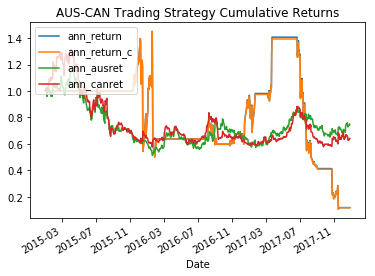

In [49]:
int1.plot(y=['ann_return', 'ann_return_c', 'ann_ausret', 'ann_canret'])
plt.title('AUS-CAN Trading Strategy Cumulative Returns')
plt.legend(loc='upper left');

### 5.3. AUS-CAN Trading Strategy Performance Metrics

#### AUS-CAN Trading Strategy Annualized Returns

In [50]:
ann_return = int1.iloc[len(int1) - 1, int1.columns.get_loc('ann_return')]   # last value from cumprod
ann_ret_c   = int1.iloc[len(int1) - 1, int1.columns.get_loc('ann_return_c')]
ann_ausret = int1.iloc[len(int1) - 1, int1.columns.get_loc('ann_ausret')]
ann_canret = int1.iloc[len(int1) - 1, int1.columns.get_loc('ann_canret')]

#### AUS-CAN Trading Strategy Annualized Standard Deviation

$$\sigma_a = \sigma * \sqrt{252}$$

In [51]:
ann_std       = np.std(int1['return']) * np.sqrt(252)
ann_std_c    = np.std(int1['return_c']) * np.sqrt(252)
ann_aus_std = np.std(int1['ausret']) * np.sqrt(252)
ann_can_std = np.std(int1['canret']) * np.sqrt(252)

#### AUS-CAN Trading Strategy Annualized Sharpe Ratio
$$sr_a = \frac{r_a - rf_a}{\sigma_a}$$

In [52]:
ann_sr        = ann_return / ann_std 
ann_sr_c     = ann_ret_c  / ann_std_c
ann_aus_sr = ann_ausret / ann_aus_std
ann_can_sr = ann_canret / ann_can_std

### AUS-CAN Trading Strategy Summary Results


In [53]:
results = [{'0': 'Annualized:', '1': 'return', '2': 'return_c', '3': 'ausret', '4': 'canret'},
        {'0': 'Return', '1': ann_return, '2': ann_ret_c, '3': ann_ausret, '4': ann_canret},
        {'0': 'Standard Deviation', '1': ann_std, '2': ann_std_c, '3': ann_aus_std, '4': ann_can_std},
        {'0': 'Sharpe Ratio (Rf=0%)', '1': ann_sr, '2': ann_sr_c, '3': ann_aus_sr, '4': ann_can_sr}]
table = pd.DataFrame(results)
print("")
print("AUS-CAN Trading Strategy Summary Results")
table


AUS-CAN Trading Strategy Summary Results


,0,1,2,3,4
0,Annualized:,return,return_c,ausret,canret
1,Return,0.118284,0.116628,0.749723,0.641443
2,Standard Deviation,0.887493,0.887513,0.346665,0.368958
3,Sharpe Ratio (Rf=0%),0.133279,0.13141,2.16267,1.73852


위의 결과는 return 과 return_c 가 Australia benchmark 보다는 낮고 Canadian benchmark 보다는 높다.

risk (std) 는 두 나라 benchmark 보다 낮다.

따라서,  commission 을 감안하여도 우리 strategy 의 Sharpe Ratio 는 두 나라 개별 benchmark 보다 높다. 